# Create and run a local RAG pipeline from scratch

## What is RAG?

RAG stand for Retrieval Augmented Generation.

The goal is to take information and pass it to an LLM so it can generate outputs based on that inforamtion.

* Retrieval - Find relevant inforamtion given a query, e.g. "what are the macronutrients and what do they do?" -> retrieves passges of text related to macronutrients from a nutrition textbook.
* Augmented - we want to relevant information and augment it with the prompt(input) and then pass it to the LLM.
* Generation - Take the first two steps and pass through them to an LLM for generative outputs.

To read more about RAG, see the Facebook AI Paper: https://arxiv.org/pdf/2005.11401.pdf

> This work offers several positive societal benefits over previous work: the fact that it is more
strongly grounded in real factual knowledge (in this case Wikipedia) makes it “hallucinate” less
with generations that are more factual, and offers more control and interpretability. RAG could be
employed in a wide variety of scenarios with direct benefit to society, for example by endowing it
with a medical index and asking it open-domain questions on that topic, or by helping people be more
effective at their jobs.

>With these advantages also come potential downsides: Wikipedia, or any potential external knowledge
source, will probably never be entirely factual and completely devoid of bias. Since RAG can be
employed as a language model, similar concerns as for GPT-2 [50] are valid here, although arguably
to a lesser extent, including that it might be used to generate abuse, faked or misleading content in
the news or on social media; to impersonate others; or to automate the production of spam/phishing
content [54]. Advanced language models may also lead to the automation of various jobs in the
coming decades [16]. In order to mitigate these risks, AI systems could be employed to fight against
misleading content and automated spam/phishing.

## Why RAG

The main goal of RAG is to improve the generation outputs of LLMs.

1. Prevent hallucinations - LLMs are incredibly good at the generating good *looking* text, however, this text doesn't mean that it's factual. RAG can help LLMs generate information based on relevant passages that are factual.
2. Work with custom data - Many base LLMs are trained with internet-scale data. This means they have a fairly good understanding of language in general.
However it also does a lot of their responses can be generic in nature. RAG helps to create specific responses based on specific documents (e.g. your own companies customer support documents).

## What can RAG be used for?
* Customer Support Q&A chat - Treat your existing customer support documents as a resource and when a customer asks a question, you could have a retrieval system, retrieval relevant documentation snippets and then have an LLM craft those snippets into an answer. Think of this as a "chatbot for your documentation"
* Email Chain Analysis - Let's say you're a large insurance company and you have chains and chains of emails of customer claims. You could use a RAG pipeline to find a relevant information from those emails and then use an LLM to process that information into structured data.
* Company internal documentation chat.
* Textbook Q&A - Let's say you're a nutrition student and you've got a 1200 page textbook read, you could build a RAG pipeline to go through the textbook and find relevant passages to the questions you have.

Common theme here: take your relevant documents to a query and process them with an LLM.

From this angle, you can consider an LLM as a calculator for words. 

## Why local ?

fun.

Privacy, Speed, Cost.

* Privacy - If you have private documentation, maybe you don't want to send that to an API. You want to setup an LLM and run it on your own hardware.
* Speed - Whenever you use an API, you have to send some kind of data across the internet. This takes time. Running locally means we don't have to wait for transfers of data.
* Cost - If you own your hardware, the cost is paid. it may have a large cost to begin with. But overtime, you don't have to keep paying API fees.
* No vendor lock-in - If you run your own software/hardware. If OpenAI/another company shut down tomorrow, you can stil run your own business.

## What I'm going to build

* https://github.com/mrdbourke/simple-local-rag
* https://whimsical.com/simple-local-rag-workflow-39kToR3yNf7E8kY4sS2tjV

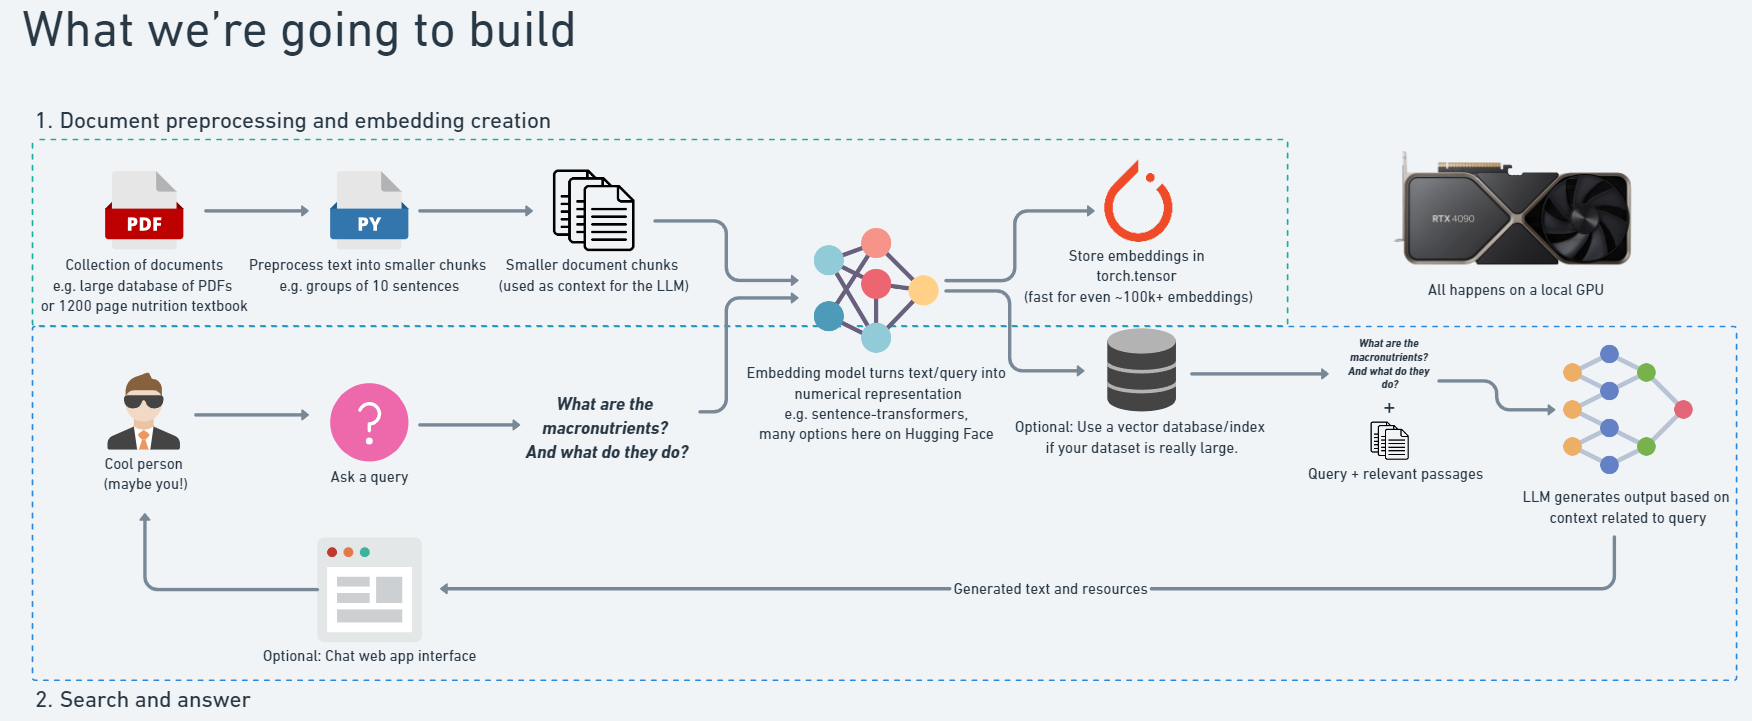

We're going to build NutriChat to "chat with a nutrition textbook".

Specifically:

1. Open a PDF document (you could use almost any PDF here or even a collection of PDFs).
2. Format the text of the PDF textboook ready for an embedding model.
3. Embed al of the chunks of text in the textbook and turn them into numerical representations (embedding) which can store for later.
4. Build a retrieval system that uses vector search to find relevant chunck of text based on a query.
5. Create a prompt that incorporates the retrieved pieces of text.
6. Generate an answer to a query based on the passages of the textbook with an LLM.

All locally!

1. Steps 1-3: Document preprocessing and embedding creation.
2. Steps 4-6: Search and Answer/

## 1. Document/text processing and embedding creation

Ingredients:
* PDF document of choice (note: this could be almost any kind of document, I've just chosen to focus on PDFs for now).
* Embedding model of choice

Steps:
1. Import PDF Document.
2. Process text embedding (e.g. split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to file for later (embedding will store on file for many years or until you lose your hard drive).

## Import PDF Document

In [2]:
import os 
import requests # to download things of the internet

# Get PDF document path
pdf_path = "RAG_Paper.pdf"

# Download PDF
if not os.path.exists(pdf_path):
    print(f"[INFO] File doesn't exist, downloading...")

    # Enter the URL of the PDF
    url = "https://arxiv.org/pdf/2005.11401"

    # The local filename to save the downloaded file
    filename = pdf_path

    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Open the file and save it
        with open(filename, "wb") as f:
            f.write(response.content)
        print(f"[INFO] the file has been downloaded and saved as {filename}")
    else:
        print(f"[INFO] Failed to downlaod the file. Status code: {response.status_code}")

else:
    print(f"File {pdf_path} exists.")

File RAG_Paper.pdf exists.


We've got a PDF, let's open it!

In [3]:
import fitz # requires: !pip install PyMuPDF 
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()

    # Potentially more text formatting functions can go here
    return cleaned_text

def open_and_read_pdf(pdf_path:str) -> list[dict]:
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 2898,
  'page_word_count': 403,
  'page_sentence_count_raw': 14,
  'page_token_count': 724.5,
  'text': 'Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks Patrick Lewis†‡, Ethan Perez⋆, Aleksandra Piktus†, Fabio Petroni†, Vladimir Karpukhin†, Naman Goyal†, Heinrich Küttler†, Mike Lewis†, Wen-tau Yih†, Tim Rocktäschel†‡, Sebastian Riedel†‡, Douwe Kiela† †Facebook AI Research; ‡University College London; ⋆New York University; plewis@fb.com Abstract Large pre-trained language models have been shown to store factual knowledge in their parameters, and achieve state-of-the-art results when ﬁne-tuned on down- stream NLP tasks. However, their ability to access and precisely manipulate knowl- edge is still limited, and hence on knowledge-intensive tasks, their performance lags behind task-speciﬁc architectures. Additionally, providing provenance for their decisions and updating their world knowledge remain open research problems. Pre- tr

In [4]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': -40,
  'page_char_count': 4554,
  'page_word_count': 659,
  'page_sentence_count_raw': 27,
  'page_token_count': 1138.5,
  'text': 'The Divine Comedy (x) q Query Encoder q(x) MIPS pθ Generator\xa0pθ (Parametric) Margin- alize This 14th century work is divided into 3 sections: "Inferno", "Purgatorio" & "Paradiso"         (y) End-to-End Backprop through q and\xa0pθ Barack Obama was born in Hawaii.(x) Fact Veriﬁcation: Fact Query supports (y) Question Generation Fact Veriﬁcation: Label Generation Document Index Define "middle ear"(x) Question Answering: Question Query The middle ear includes the tympanic cavity and the three ossicles.  (y) Question Answering: Answer Generation Retriever pη (Non-Parametric) z4 z3 z2 z1 d(z) Jeopardy Question Generation: Answer Query Figure 1: Overview of our approach. We combine a pre-trained retriever (Query Encoder + Document Index) with a pre-trained seq2seq model (Generator) and ﬁne-tune end-to-end. For query x, we use Maximum Inner Pr

In [5]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,2898,403,14,724.50,Retrieval-Augmented Generation for Knowledge-I...
1,-40,4554,659,27,1138.50,The Divine Comedy (x) q Query Encoder q(x) MIP...
2,-39,3676,569,25,919.00,by θ that generates a current token based on a...
3,-38,4227,681,35,1056.75,minimize the negative marginal log-likelihood ...
4,-37,4551,693,35,1137.75,MSMARCO as an open-domain abstractive QA task....


In [6]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,19.00,19.00,19.00,19.00,19.00
mean,-32.00,3635.00,521.11,37.53,908.75
std,5.63,909.47,148.57,20.35,227.37
min,-41.00,1137.00,147.00,13.00,284.25
25%,-36.50,3417.50,463.00,22.50,854.38
50%,-32.00,3985.00,516.00,35.00,996.25
75%,-27.50,4174.50,656.00,54.00,1043.62
max,-23.00,4554.00,708.00,70.00,1138.50


Why would we care about token count?

Token count is important to think about because:
1. Embedding models don't deal with infinite tokens.
2. LLMs don't deal with infinite tokens.

For example an embedding model may have been trained to embed sequences of 384 tokens into numerical space (setence-transformers `all-mpnet-base-v2`, see: https://www.sbert.net/docs/pretrained_models.html).

As for LLMs, they can't except infinite tokens in their context window.

### Further text processing (Splitting pages into setences)

Two ways to do this:
1. We've done this by splitting on `". "`.
2. We've can do this with a NLP library such as spaCy (https://spacy.io/usage) and nltk (https://www.nltk.org).

In [7]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline, see: https://spacy.io/api/sentencizer
nlp.add_pipe("sentencizer")

# Create document instance as an example
doc = nlp("This is a sentence. This another sentence. I like elephants.")
assert len(list(doc.sents)) == 3 

# print out our sentences split
list(doc.sents)

[This is a sentence., This another sentence., I like elephants.]

In [8]:
for item in tqdm(pages_and_texts):
    item['setences'] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings (the deafult type is a spaCy datatype)
    item['setences'] = [str(sentence) for sentence in item['setences']]

    # Count the sentences
    item['page_sentences_count_spacy'] = len(item['setences'])

  0%|          | 0/19 [00:00<?, ?it/s]

In [9]:
random.sample(pages_and_texts, k=1)

[{'page_number': -23,
  'page_char_count': 1962,
  'page_word_count': 298,
  'page_sentence_count_raw': 13,
  'page_token_count': 490.5,
  'text': 'Table 7: Number of instances in the datasets used. *A hidden subset of this data is used for evaluation Task Train Development Test Natural Questions 79169 8758 3611 TriviaQA 78786 8838 11314 WebQuestions 3418 362 2033 CuratedTrec 635 134 635 Jeopardy Question Generation 97392 13714 26849 MS-MARCO 153726 12468 101093* FEVER-3-way 145450 10000 10000 FEVER-2-way 96966 6666 6666 parameters. The best performing "closed-book" (parametric only) open-domain QA model is T5-11B with 11 Billion trainable parameters. The T5 model with the closest number of parameters to our models is T5-large (770M parameters), which achieves a score of 28.9 EM on Natural Questions [52], substantially below the 44.5 that RAG-Sequence achieves, indicating that hybrid parametric/non- parametric models require far fewer trainable parameters for strong open-domain QA perf

In [10]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentences_count_spacy
count,19.00,19.00,19.00,19.00,19.00,19.00
mean,-32.00,3635.00,521.11,37.53,908.75,34.89
std,5.63,909.47,148.57,20.35,227.37,16.88
min,-41.00,1137.00,147.00,13.00,284.25,13.00
25%,-36.50,3417.50,463.00,22.50,854.38,22.50
50%,-32.00,3985.00,516.00,35.00,996.25,35.00
75%,-27.50,4174.50,656.00,54.00,1043.62,47.50
max,-23.00,4554.00,708.00,70.00,1138.50,63.00


### Chunking our sentences together

The concept of splitting larger pieces of text into smaller ones is often referred to as text splitting or chunking.

There is no 100% correct way to do this.

We'll keep it simple and split into groups of 10 setences (however, you could also try 5, 7, 8, whatever you like).

There are frameworks such as LangChain that can help with this, however, we'll stick with python now: https://python.langchain.com/docs/modules/data_connection/document_transformers/

Why we do this:
1. So our texts are easier to filter (smaller groups of text can be easier to inspect that large passages of text).
2. So our text chunks can fit into our embedding model context window (e.g. 384 tokens as a limit).
3. So our contexts passed to an LLM can be more specific and focused.

In [11]:
# Define split size to turn groups of setences into chucks
num_sentence_chunk_size = 10

# Create a function to split lists of texts recursively into chuck size
# e.g. [20] -> [10, 10] or [25] -> [10, 10, 5]
def split_list(input_list: list[str],
               split_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i + split_size] for i in range(0, len(input_list), split_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [12]:
# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item['setences'],
                                        split_size= num_sentence_chunk_size)
    item['num_chunks'] = len(item['sentence_chunks'])

  0%|          | 0/19 [00:00<?, ?it/s]

In [13]:
random.sample(pages_and_texts, k=1)

[{'page_number': -27,
  'page_char_count': 4005,
  'page_word_count': 498,
  'page_sentence_count_raw': 70,
  'page_token_count': 1001.25,
  'text': '[56] James Thorne, Andreas Vlachos, Christos Christodoulopoulos, and Arpit Mittal. FEVER: a large-scale dataset for fact extraction and VERiﬁcation. In Proceedings of the 2018 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long Papers), pages 809–819, New Orleans, Louisiana, June 2018. Association for Computational Linguistics. doi: 10.18653/v1/N18-1074. URL https://www.aclweb.org/anthology/N18-1074. [57] James H. Thorne and Andreas Vlachos. Avoiding catastrophic forgetting in mitigating model biases in sentence-pair classiﬁcation with elastic weight consolidation. ArXiv, abs/2004.14366, 2020. URL https://arxiv.org/abs/2004.14366. [58] Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Ł ukasz Kaiser, and Illia Polosukhi

In [14]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentences_count_spacy,num_chunks
count,19.00,19.00,19.00,19.00,19.00,19.00,19.0
mean,-32.00,3635.00,521.11,37.53,908.75,34.89,4.0
std,5.63,909.47,148.57,20.35,227.37,16.88,1.7
min,-41.00,1137.00,147.00,13.00,284.25,13.00,2.0
25%,-36.50,3417.50,463.00,22.50,854.38,22.50,3.0
50%,-32.00,3985.00,516.00,35.00,996.25,35.00,4.0
75%,-27.50,4174.50,656.00,54.00,1043.62,47.50,5.5
max,-23.00,4554.00,708.00,70.00,1138.50,63.00,7.0


### Splitting each chuck into its own item

We'd like to embed each chunk of setences into its own numerical representation.

That'll give us a good level of gradularity.

Meaning, we can dive specifically into the text sample that was used in our model.

In [15]:
import re 

# split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict['page_number'] = item['page_number']

        # Join the sentences together into a paragraph-like structure, aka join the list of sentences into one paragraph
        joined_sentences_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentences_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentences_chunk)

        chunk_dict['sentence_chunk'] = joined_sentences_chunk

        # Get some stats on our chunks
        chunk_dict['chunk_char_count'] = len(joined_sentences_chunk)
        chunk_dict['chunk_word_count'] = len([word for word in joined_sentences_chunk.split(' ')])
        chunk_dict['chunk_token_count'] = len(joined_sentences_chunk) / 4 

        pages_and_chunks.append(chunk_dict)


len(pages_and_texts)

  0%|          | 0/19 [00:00<?, ?it/s]

19

In [16]:
random.sample(pages_and_chunks, k=1)

[{'page_number': -37,
  'sentence_chunk': 'We use the splits from SearchQA [10], with 100K train, 14K dev, and 27K test examples. As this is a new task, we train a BART model for comparison. Following [67], we evaluate using the SQuAD-tuned Q-BLEU-1 metric [42]. Q-BLEU is a variant of BLEU with a higher weight for matching entities and has higher correlation with human judgment for question generation than standard metrics. We also perform two human evaluations, one to assess generation factuality, and one for speciﬁcity. We deﬁne factuality as whether a statement can be corroborated by trusted external sources, and speciﬁcity as high mutual dependence between the input and output [33]. We follow best practice and use pairwise comparative evaluation [34]. Evaluators are shown an answer and two generated questions, one from BART and one from RAG. They are then asked to pick one of four options—quuestion A is better, question B is better, both are good, or neither is good.3.4 Fact Veriﬁc

In [17]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,76.00,76.00,76.00,76.00
mean,-31.75,907.07,129.34,226.77
std,4.80,485.55,79.66,121.39
min,-41.00,48.00,2.00,12.00
25%,-36.00,638.50,75.50,159.62
50%,-31.00,770.00,97.00,192.50
75%,-28.00,1212.00,185.75,303.00
max,-23.00,2107.00,313.00,526.75


### Filter chunks of texts for short chunks

These chunks may not contain much useful information.

In [18]:
min_token_length = 15
for row in df[df["chunk_token_count"] <= min_token_length].sample(1).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 12.0 | Text: URL https://www.aclweb.org/anthology/P17-1020.10


In [19]:
# Filter our Dataframe for rows with under 15 tokens
pages_and_chunks_over_min_token_len = df[df['chunk_char_count'] > min_token_length].to_dict(orient='records')
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -41,
  'sentence_chunk': 'Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks Patrick Lewis†‡, Ethan Perez⋆, Aleksandra Piktus†, Fabio Petroni†, Vladimir Karpukhin†, Naman Goyal†, Heinrich Küttler†, Mike Lewis†, Wen-tau Yih†, Tim Rocktäschel†‡, Sebastian Riedel†‡, Douwe Kiela† †Facebook AI Research; ‡University College London; ⋆New York University; plewis@fb.com Abstract Large pre-trained language models have been shown to store factual knowledge in their parameters, and achieve state-of-the-art results when ﬁne-tuned on down- stream NLP tasks. However, their ability to access and precisely manipulate knowl- edge is still limited, and hence on knowledge-intensive tasks, their performance lags behind task-speciﬁc architectures. Additionally, providing provenance for their decisions and updating their world knowledge remain open research problems. Pre- trained models with a differentiable access mechanism to explicit non-parametric memory have so far been on

In [20]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': -28,
  'sentence_chunk': 'id=025X0zPfn. [49] Alec Radford, Karthik Narasimhan, Tim Salimans, and Ilya Sutskever. Im- proving Language Understanding by Generative Pre-Training, 2018. URL https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/ language-unsupervised/language_understanding_paper.pdf. [50] Alec Radford, Jeff Wu, Rewon Child, David Luan, Dario Amodei, and Ilya Sutskever. Language models are unsupervised multitask learners, 2019. URL https://d4mucfpksywv.cloudfront.net/better-language-models/language_ models_are_unsupervised_multitask_learners.pdf. [51] Colin Raffel, Noam Shazeer, Adam Roberts, Katherine Lee, Sharan Narang, Michael Matena, Yanqi Zhou, Wei Li, and Peter J. Liu. Exploring the limits of transfer learning with a uniﬁed text-to-text transformer.arXiv e-prints, 2019.',
  'chunk_char_count': 782,
  'chunk_word_count': 80,
  'chunk_token_count': 195.5}]

### Embedding out text chunks

Embeddings are a broad but powerful concept.

While humans understand text, machines understand numbers.

What we'd like to do:
- Turn our text chunks into numbers, specifically embeddings.

A useful numerical representation.

The best part about embeddings is that are a *learned* representation.

HuggingFace Massive Text Embedding Leaderboard, source: https://huggingface.co/spaces/mteb/leaderboard

In [21]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device='cpu')

# Create a list of sentences
sentences = ["The Setence Transformer library provides an easy way to create embeddings.",
             "Sentences can be embedded one by one or in a list.",
             "I like cats!"]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print(f'Sentence: {sentence}')
    print(f'Embedding: {embedding}')
    print(" ")

Sentence: The Setence Transformer library provides an easy way to create embeddings.
Embedding: [-8.30300972e-02  4.11825720e-03 -1.12219797e-02  1.92858968e-02
 -8.08160566e-03 -4.79180412e-03  4.60749641e-02 -2.13632435e-02
  1.87539437e-03 -3.34673412e-02  1.87005401e-02  5.25698774e-02
 -4.43951376e-02  3.27704102e-02  3.45205478e-02 -7.26827756e-02
  7.80932372e-03  1.16380351e-02 -7.13784769e-02 -1.57887749e-02
  9.34599154e-03 -3.54287052e-03  3.59635428e-02  9.40882787e-03
 -2.53848452e-02  6.02490082e-03 -2.26813555e-02 -3.99589762e-02
  6.47121072e-02  1.78947856e-04 -3.42535712e-02  1.40055940e-02
  5.12128398e-02  1.52951786e-02  1.36576421e-06 -1.50088696e-02
 -2.50498243e-02  3.40762287e-02  3.57479081e-02  3.10622482e-03
  3.51033956e-02 -3.49813178e-02 -1.00500872e-02  1.87695529e-02
 -3.35583538e-02 -1.80557126e-03  3.87383737e-02 -1.36828693e-02
  7.32082352e-02 -1.79939512e-02 -1.60202309e-02 -2.67539043e-02
  8.84456281e-03 -2.65520252e-03  2.48888619e-02  2.7040276

In [22]:
embeddings[0].shape

(768,)

In [23]:
%%time

embedding_model.to("cpu")

# Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item['embedding'] = embedding_model.encode(item['sentence_chunk'])

  0%|          | 0/76 [00:00<?, ?it/s]

CPU times: total: 2min 1s
Wall time: 21.8 s


In [32]:
%%time

# Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item['embedding'] = embedding_model.encode(item['sentence_chunk'])

  0%|          | 0/76 [00:00<?, ?it/s]

CPU times: total: 1min 59s
Wall time: 22.2 s


In [31]:
import torch
print(torch.cuda.is_available())

False
